In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json


!kaggle competitions download -c ultrasound-nerve-segmentation
!unzip /content/ultrasound-nerve-segmentation.zip -d /content/kaggle/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/kaggle/train/34_114_mask.tif  
  inflating: /content/kaggle/train/34_115.tif  
  inflating: /content/kaggle/train/34_115_mask.tif  
  inflating: /content/kaggle/train/34_116.tif  
  inflating: /content/kaggle/train/34_116_mask.tif  
  inflating: /content/kaggle/train/34_117.tif  
  inflating: /content/kaggle/train/34_117_mask.tif  
  inflating: /content/kaggle/train/34_118.tif  
  inflating: /content/kaggle/train/34_118_mask.tif  
  inflating: /content/kaggle/train/34_119.tif  
  inflating: /content/kaggle/train/34_119_mask.tif  
  inflating: /content/kaggle/train/34_11_mask.tif  
  inflating: /content/kaggle/train/34_12.tif  
  inflating: /content/kaggle/train/34_12_mask.tif  
  inflating: /content/kaggle/train/34_13.tif  
  inflating: /content/kaggle/train/34_13_mask.tif  
  inflating: /content/kaggle/train/34_14.tif  
  inflating: /content/kaggle/train/34_14_mask.tif  
  inflating: /content/kaggle/train

## Instalando e Carregando os Pacotes

In [ ]:
!pip install -q tensorflow==2.13.0 scikit-image==0.20.0 numpy==1.23.4 scikit-learn==1.3.0 pandas==1.5.3 pillow==9.4.0 watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.7 MB/s eta 0:00:00


In [2]:
# Imports
import re
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import skimage
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Version 0" --iversions

Author: Version 0

skimage   : 0.20.0
pandas    : 1.5.3
sklearn   : 1.3.0
PIL       : 9.4.0
numpy     : 1.23.4
tensorflow: 2.13.0
matplotlib: 3.7.1
re        : 2.2.1



## Organizando as Imagens em Disco

In [3]:
# Carrega o arquivo CSV
df_dsa = pd.read_csv('/content/kaggle/train_masks.csv')

In [4]:
df_dsa.shape

(5635, 3)

In [5]:
df_dsa.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


In [6]:
# Caminho para imagens de treino e teste
caminho_treino = os.listdir('/content/kaggle/train')
caminho_teste = os.listdir('/content/kaggle/test/')

In [7]:
print(len(caminho_treino), len(caminho_teste))

11270 5508


> Vamos usar expressão regular para extrair os nomes dos arquivos.

In [8]:
# Compila uma expressão regular que busca por uma ou mais sequências numéricas.
reg = re.compile("[0-9]+")

# Mapeia cada item em 'caminho_treino', procura por uma sequência numérica e retorna o primeiro match.
temp1 = list(map(lambda x: reg.match(x).group(), caminho_treino))

# Converte todos os itens de 'temp1' (que são strings) para inteiros.
temp1 = list(map(int, temp1))

# Mapeia cada item em 'caminho_treino', divide a string pelo caractere '_', pega o segundo item resultante,
# procura por uma sequência numérica e retorna o primeiro match.
temp2 = list(map(lambda x: reg.match(x.split("_")[1]).group(), caminho_treino))

# Converte todos os itens de 'temp2' (que são strings) para inteiros.
temp2 = list(map(int, temp2))

# Combina 'temp1', 'temp2' e 'caminho_treino' e ordena a combinação usando 'temp1' e 'temp2' como chaves
# de ordenação, depois pega apenas os valores de 'caminho_treino'.
caminho_treino = [x for _,_,x in sorted(zip(temp1, temp2, caminho_treino))]

# Exibe os primeiros 20 itens da lista 'caminho_treino'.
caminho_treino[:20]

['1_1.tif',
 '1_1_mask.tif',
 '1_2.tif',
 '1_2_mask.tif',
 '1_3.tif',
 '1_3_mask.tif',
 '1_4.tif',
 '1_4_mask.tif',
 '1_5.tif',
 '1_5_mask.tif',
 '1_6.tif',
 '1_6_mask.tif',
 '1_7.tif',
 '1_7_mask.tif',
 '1_8.tif',
 '1_8_mask.tif',
 '1_9.tif',
 '1_9_mask.tif',
 '1_10.tif',
 '1_10_mask.tif']

In [9]:
len(caminho_treino)

11270

In [10]:
# Listas
imagens_treino = []
mascaras_treino = []

In [11]:
# Itera sobre os índices e itens da lista 'caminho_treino'.
for index, item in enumerate(caminho_treino):

    # Verifica se o índice é par.
    if index % 2 == 0:

        # Se o índice for par, adiciona o item à lista 'imagens_treino'.
        imagens_treino.append(item)
    else:

        # Se o índice for ímpar, adiciona o item à lista 'mascaras_treino'.
        mascaras_treino.append(item)

In [12]:
print(len(imagens_treino))
print(len(mascaras_treino))

5635
5635


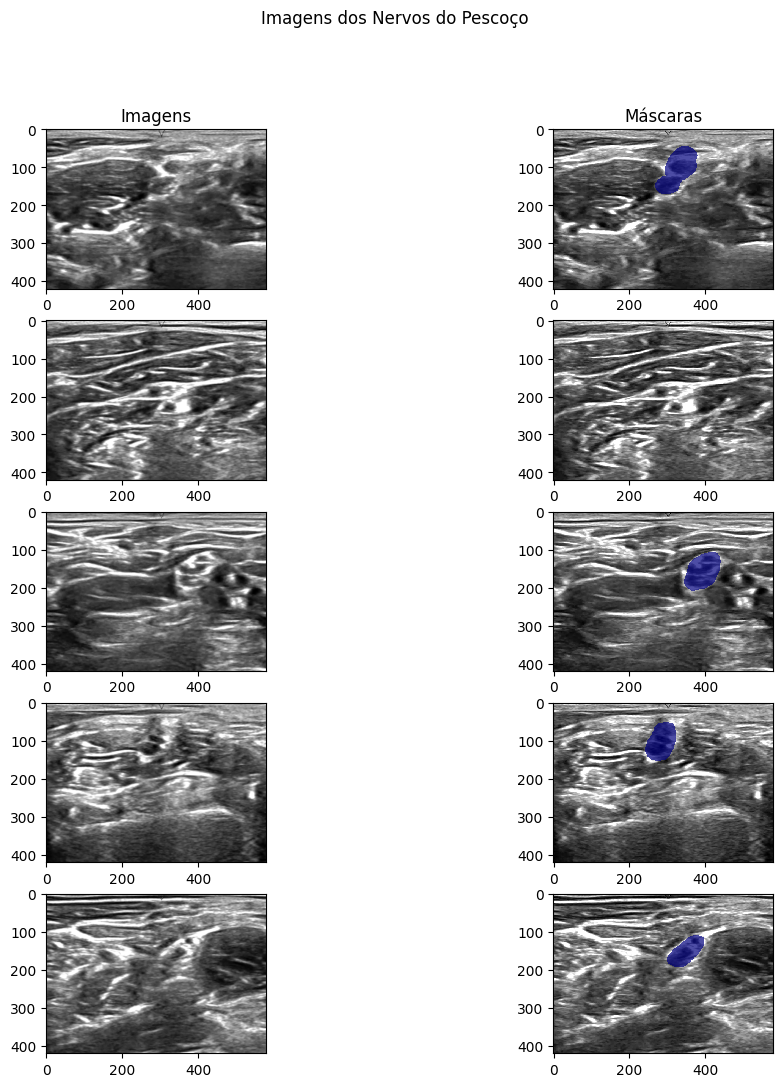

In [14]:
# Plot
fig , ax = plt.subplots(5, 2, figsize = [12, 12])
fig.suptitle('Imagens dos Nervos do Pescoço')
ax[0 , 0].set_title('Imagens')
ax[0 , 1].set_title('Máscaras')

# Loop
for i in range(0, 5):

    # Imagem
    ind = random.randint(0, len(imagens_treino))
    img1 = np.array(Image.open("/content/kaggle/train/" + str(imagens_treino[ind])))
    ax[i , 0].imshow(img1, cmap = 'gray')

    # Máscara
    img2 = np.array(Image.open("/content/kaggle/train/" + str(mascaras_treino[ind])))
    img2 = np.ma.masked_where(img2 == 0, img2)
    ax[i , 1].imshow(img1, cmap = 'gray' , interpolation = 'none')
    ax[i , 1].imshow(img2, cmap = 'jet', interpolation = 'none', alpha = 0.7)

plt.show()

## Pré-Processamento das Imagens

In [ ]:
# Cria as matrizes X e y que serão preenchidas com as transformações de imagens e máscaras
X = np.zeros((len(imagens_treino), 128, 128, 1), dtype = np.float32)
y = np.zeros((len(mascaras_treino), 128, 128, 1), dtype = np.float32)

> Pré-Processamento das Imagens.

In [ ]:
# Itera sobre os índices (n) e os nomes das imagens (img_name) na lista 'imagens_treino'.
for n, img_name in enumerate(imagens_treino):

    # Carrega a imagem do diretório '/content/kaggle/train' com o nome 'img_name' no modo escala de cinza (grayscale).
    img = tf.keras.preprocessing.image.load_img('/content/kaggle/train/' + img_name, color_mode = "grayscale")

    # Converte a imagem carregada (img) para um array numpy.
    in_img = tf.keras.preprocessing.image.img_to_array(img)

    # Redimensiona a imagem para as dimensões (128, 128, 1) usando o método 'constant' e
    # mantendo o intervalo original.
    in_img = skimage.transform.resize(in_img, (128, 128, 1), mode = 'constant', preserve_range = True)

    # Normaliza a imagem dividindo cada pixel por 255 e atribui a imagem normalizada à n-ésima posição
    # da lista/array X.
    X[n] = in_img / 255.0

> Pré-Processamento das Máscaras.

In [ ]:
# Itera sobre os índices (n) e os nomes das máscaras (img_name) na lista 'mascaras_treino'.
for n, img_name in enumerate(mascaras_treino):

    # Carrega a imagem de máscara do diretório '/content/kaggle/train/' com o nome 'img_name' no modo escala de
    # cinza (grayscale).
    img = tf.keras.preprocessing.image.load_img('/content/kaggle/train/' + img_name, color_mode = "grayscale")

    # Converte a imagem de máscara carregada (img) para um array numpy.
    in_img = tf.keras.preprocessing.image.img_to_array(img)

    # Redimensiona a imagem de máscara para as dimensões (128, 128, 1) usando o método 'constant' e
    # mantendo o intervalo original.
    in_img = skimage.transform.resize(in_img, (128, 128, 1), mode = 'constant', preserve_range = True)

    # Normaliza a imagem de máscara dividindo cada pixel por 255 e atribui a imagem de máscara
    # normalizada à n-ésima posição da lista/array y.
    y[n] = in_img / 255.0

In [ ]:
# Dividimos os dados em treino e validação
X_treino , X_valid , y_treino , y_valid = train_test_split(X, y, test_size = 0.1 , random_state = 42)

In [ ]:
len(X_treino)

5071

In [ ]:
len(X_valid)

564

## Arquitetura do Modelo

In [ ]:
# Define uma função chamada 'Conv2D_Block' que aceita um tensor de entrada e um número de filtros.
def Conv2D_Block(input_tensor, n_filters):

    # Adiciona uma camada convolucional 2D ao tensor de entrada com o número especificado de filtros,
    # tamanho do kernel (3x3), inicializador 'he_normal' e padding 'same'.
    x = tf.keras.layers.Conv2D(filters = n_filters,
                               kernel_size = (3, 3),
                               kernel_initializer = 'he_normal',
                               padding = 'same')(input_tensor)

    # Adiciona uma camada de normalização em lote ao tensor resultante da operação anterior.
    x = tf.keras.layers.BatchNormalization()(x)

    # Adiciona uma camada de ativação ReLU ao tensor resultante da operação anterior.
    x = tf.keras.layers.Activation('relu')(x)

    # Adiciona outra camada convolucional 2D ao tensor resultante com o número especificado de filtros,
    # tamanho do kernel (3x3), inicializador 'he_normal' e padding 'same'.
    x = tf.keras.layers.Conv2D(filters = n_filters,
                               kernel_size = (3, 3),
                               kernel_initializer = 'he_normal',
                               padding = 'same')(x)

    # Adiciona outra camada de normalização em lote ao tensor resultante da operação anterior.
    x = tf.keras.layers.BatchNormalization()(x)

    # Adiciona outra camada de ativação ReLU ao tensor resultante da operação anterior.
    x = tf.keras.layers.Activation('relu')(x)

    # Retorna o tensor resultante após todas as operações.
    return x

In [ ]:
# Define uma função chamada 'U_Net' que constrói uma arquitetura U-Net a partir de um tensor
# de imagem e número de filtros.
def U_Net(img_tensor, n_filters = 16):

    # Primeira etapa de contração da U-Net.
    # Aplica o bloco convolucional no tensor da imagem.
    conv1 = Conv2D_Block(img_tensor, n_filters * 1)

    # Realiza pooling para reduzir dimensionalidade.
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    # Aplica dropout para prevenir overfitting.
    pool1 = tf.keras.layers.Dropout(0.05)(pool1)

    # Segunda etapa de contração da U-Net.
    conv2 = Conv2D_Block(pool1, n_filters * 2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    pool2 = tf.keras.layers.Dropout(0.05)(pool2)

    # Terceira etapa de contração da U-Net.
    conv3 = Conv2D_Block(pool2, n_filters * 4)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    pool3 = tf.keras.layers.Dropout(0.05)(pool3)

    # Quarta etapa de contração da U-Net.
    conv4 = Conv2D_Block(pool3, n_filters * 8)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(0.05)(pool4)

    # Ponto mais profundo da U-Net (não é reduzido posteriormente).
    conv5 = Conv2D_Block(pool4, n_filters * 16)

    # Primeira etapa de expansão da U-Net.
    # Operação transposta da convolução.
    pool6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), (2, 2), padding = 'same')(conv5)

    # Concatena com a saída convolucional da etapa correspondente de contração.
    pool6 = tf.keras.layers.concatenate([pool6, conv4])
    pool6 = tf.keras.layers.Dropout(0.05)(pool6)
    conv6 = Conv2D_Block(pool6, n_filters * 8)

    # Segunda etapa de expansão da U-Net.
    pool7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), (2, 2), padding = 'same')(conv6)
    pool7 = tf.keras.layers.concatenate([pool7, conv3])
    pool7 = tf.keras.layers.Dropout(0.05)(pool7)
    conv7 = Conv2D_Block(pool7, n_filters*4)

    # Terceira etapa de expansão da U-Net.
    pool8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), (2, 2), padding = 'same')(conv7)
    pool8 = tf.keras.layers.concatenate([pool8, conv2])
    pool8 = tf.keras.layers.Dropout(0.05)(pool8)
    conv8 = Conv2D_Block(pool8, n_filters*2)

    # Quarta etapa de expansão da U-Net.
    pool9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), (2, 2), padding = 'same')(conv8)
    pool9 = tf.keras.layers.concatenate([pool9, conv1])
    pool9 = tf.keras.layers.Dropout(0.05)(pool9)
    conv9 = Conv2D_Block(pool9, n_filters * 1)

    # Camada de saída.
    # Usa uma camada convolucional para produzir a saída final.
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)

    # Monta o modelo U-Net usando o tensor de imagem como entrada e a saída calculada.
    u_net = tf.keras.Model(inputs = [img_tensor], outputs = [output])

    return u_net

In [ ]:
# Tensor de input
img_tensor = tf.keras.layers.Input((128, 128 , 1), name = 'img')

In [ ]:
# Cria o modelo
modelo_dsa = U_Net(img_tensor)

In [ ]:
# Use esta opção para processadores Apple M1/M2
modelo_dsa.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

# Use esta opção para outros processadores
# modelo_dsa.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
modelo_dsa.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['img[0][0]']                 
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 10, verbose = 1),
    tf.keras.callbacks.ReduceLROnPlateau(factor = 0.1, patience = 5, min_lr = 0.00001, verbose = 1),
    tf.keras.callbacks.ModelCheckpoint('modelos/modelo.h5',
                                       verbose = 1,
                                       save_best_only = True,
                                       save_weights_only = True)]

> Agora treinamos o modelo.

In [ ]:
# Hiperparâmetros
batch = 32
num_epochs = 10

In [ ]:
%%time
hist_treino = modelo_dsa.fit(X_treino,
                             y_treino,
                             batch_size = batch,
                             epochs = num_epochs,
                             callbacks = callbacks,
                             validation_data = (X_valid, y_valid))

Epoch 1/10
159/159 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.9121
Epoch 1: val_loss improved from inf to 0.31336, saving model to modelos/modelo_dsa.h5
159/159 [==============================] - 37s 141ms/step - loss: 0.3836 - accuracy: 0.9121 - val_loss: 0.3134 - val_accuracy: 0.9828 - lr: 0.0010
Epoch 2/10
159/159 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9829
Epoch 2: val_loss improved from 0.31336 to 0.13956, saving model to modelos/modelo_dsa.h5
159/159 [==============================] - 19s 121ms/step - loss: 0.1540 - accuracy: 0.9829 - val_loss: 0.1396 - val_accuracy: 0.9828 - lr: 0.0010
Epoch 3/10
159/159 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9829
Epoch 3: val_loss improved from 0.13956 to 0.07238, saving model to modelos/modelo_dsa.h5
159/159 [==============================] - 19s 121ms/step - loss: 0.0812 - accuracy: 0.9829 - val_loss: 0.0724 - val_accuracy: 0.9828 - lr: 0.0010
Epoch

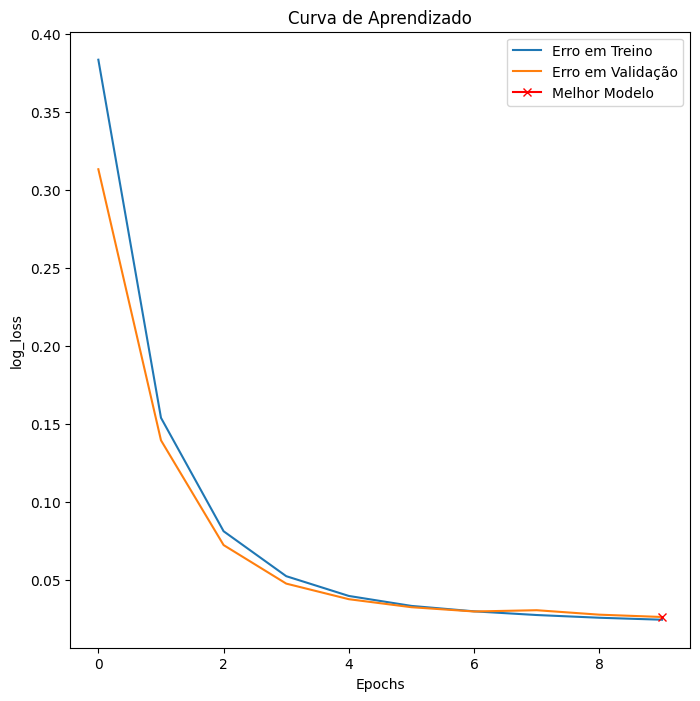

In [ ]:
# Plot
plt.figure(figsize = (8, 8))
plt.title("Curva de Aprendizado")
plt.plot(hist_treino.history["loss"], label = "Erro em Treino")
plt.plot(hist_treino.history["val_loss"], label = "Erro em Validação")
plt.plot(np.argmin(hist_treino.history["val_loss"]),
         np.min(hist_treino.history["val_loss"]),
         marker = "x",
         color = "r",
         label = "Melhor Modelo")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Carrega a imagem do disco
modelo_dsa.load_weights('modelos/modelo.h5')

In [ ]:
# Avalia o modelo
modelo_dsa.evaluate(X_valid, y_valid, verbose = 1)

18/18 [==============================] - 1s 31ms/step - loss: 0.0263 - accuracy: 0.9828


[0.026263682171702385, 0.9828471541404724]

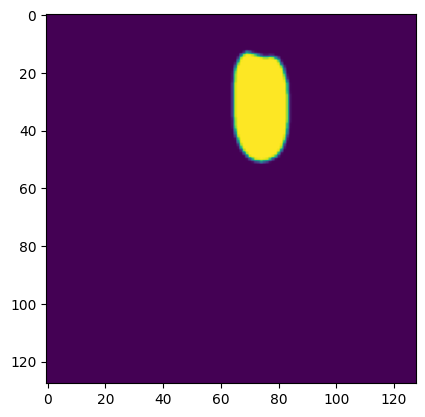

In [ ]:
# Previsão em Validação
plt.imshow(y_valid[0].squeeze())

## Uso do Modelo com Novas Imagens

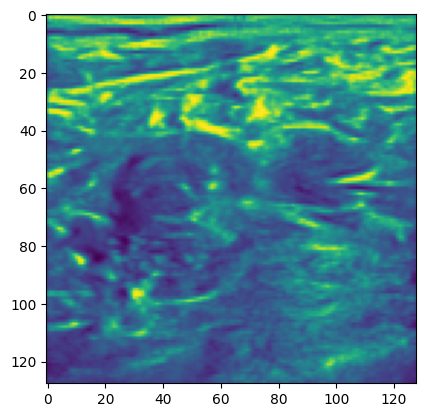

In [ ]:
# Define nova imagem e faz o mesmo pré-processamento feito em dados de treino
img_name = '3291.tif'
img = tf.keras.preprocessing.image.load_img('/content/kaggle/test/' + img_name, color_mode = "grayscale")
in_img = tf.keras.preprocessing.image.img_to_array(img)
in_img = skimage.transform.resize(in_img , (128 , 128 , 1), mode = 'constant', preserve_range = True)
test = in_img / 255.0
plt.imshow(test.squeeze())

In [ ]:
# Previsão
prediction = modelo_dsa.predict(np.expand_dims(test , 0))

1/1 [==============================] - 2s 2s/step


In [ ]:
# Shape
prediction.shape

(1, 128, 128, 1)

In [ ]:
# Ajusta o shape
prediction.squeeze().shape

(128, 128)

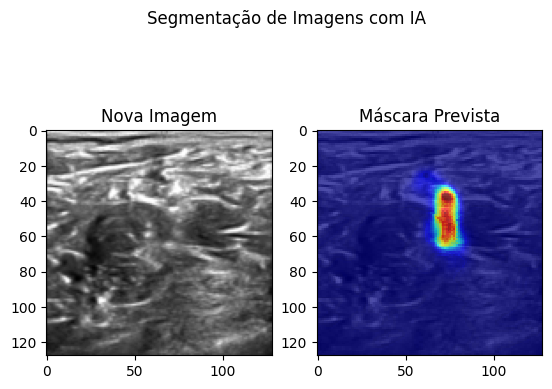

In [ ]:
# Plot
fig , ax = plt.subplots(1 , 2)
fig.suptitle('Segmentação de Imagens com IA')
ax[0].set_title('Nova Imagem')
ax[1].set_title('Máscara Prevista')
img1 = test.squeeze()
ax[0].imshow(img1, cmap = 'gray')

img2 = prediction.squeeze()
img2 = np.ma.masked_where(img2 == 0, img2)
ax[1].imshow(img1, cmap = 'gray' , interpolation = 'none')
ax[1].imshow(img2, cmap = 'jet', interpolation = 'none', alpha = 0.7)

plt.show()

1/1 [==============================] - 0s 43ms/step


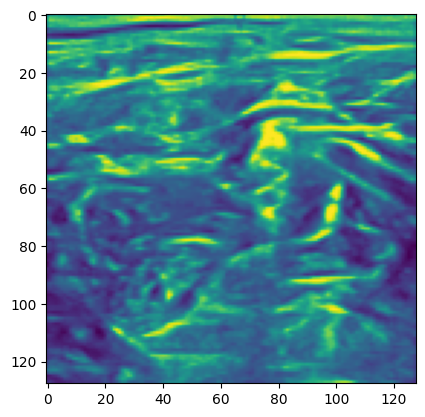

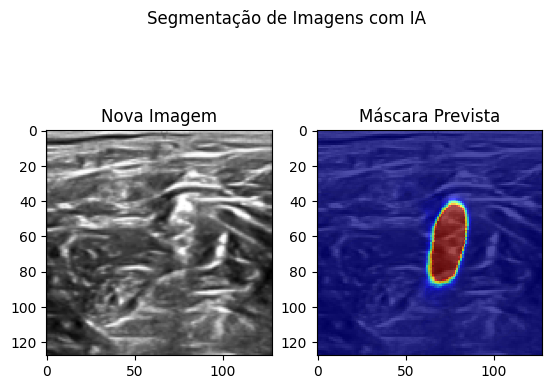

In [ ]:
# Define nova imagem e faz o mesmo pré-processamento feito em dados de treino
img_name = '5115.tif'
img = tf.keras.preprocessing.image.load_img('/content/kaggle/test/' + img_name , color_mode = "grayscale")
in_img = tf.keras.preprocessing.image.img_to_array(img)
in_img = skimage.transform.resize(in_img , (128 , 128 , 1), mode = 'constant', preserve_range = True)
test = in_img / 255.0
plt.imshow(test.squeeze())

# Previsão
prediction = modelo_dsa.predict(np.expand_dims(test , 0))

# Ajusta o shape
prediction.squeeze().shape

# Plot
fig , ax = plt.subplots(1 , 2)
fig.suptitle('Segmentação de Imagens com IA')
ax[0].set_title('Nova Imagem')
ax[1].set_title('Máscara Prevista')
img1 = test.squeeze()
ax[0].imshow(img1, cmap = 'gray')

img2 = prediction.squeeze()
img2 = np.ma.masked_where(img2 == 0, img2)
ax[1].imshow(img1, cmap = 'gray' , interpolation = 'none')
ax[1].imshow(img2, cmap = 'jet', interpolation = 'none', alpha = 0.7)

plt.show()

In [ ]:
# Fim